Topic: Implementing Quantum Support Vector Machine 

Group-6 Members:
Ronak Nahata-201701416
Param Shah-201701413
Megh Shah-201701403
Ronak Jain-201701419

In [2]:
!pip install qiskit;

     |████████████████████████████████| 8.5MB 8.7MB/s 
     |████████████████████████████████| 17.6MB 1.2MB/s 
     |████████████████████████████████| 204kB 50.9MB/s 
     |████████████████████████████████| 204kB 50.6MB/s 
     |████████████████████████████████| 2.1MB 16.6MB/s 
     |████████████████████████████████| 1.3MB 20.1MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 5.9MB 13.8MB/s 
     |████████████████████████████████| 194kB 38.5MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 614kB 47.5MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 2.6MB 36.6MB/s 
     |████████████████████████████████| 5.5MB 44.6MB/s 
  Created wheel for qiskit: filename=qiskit-0.23.2-cp36-none-any.whl size=2876 sha256=cb206cab9b5810750c91f456e47e12f658cf1ab315a0030857ace9423b165bfe
  Stored in directory: /root/.cache/pip/wheels/c2/62/3e/d5aeec3b19ba0e2

In [7]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']
    
    cancer = datasets.load_breast_cancer()
    

    X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)
    

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    

    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

 
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

 
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]
            
            label = 'Malignant' if k is 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()
        

    return X_train, training_input, test_input, class_labels



class svm_utils:

	def make_meshgrid(x, y, h=.02):

	    x_min, x_max = x.min() - 1, x.max() + 1
	    y_min, y_max = y.min() - 1, y.max() + 1
	    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
		                 np.arange(y_min, y_max, h))
	    return xx, yy


	def plot_contours(ax, clf, xx, yy, **params):
	    
	    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
	    Z = Z.reshape(xx.shape)
	    out = ax.contourf(xx, yy, Z, **params)
	    return out


## Breast Cancer dataset

In [8]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from qiskit.aqua.utils import split_dataset_to_data_and_labels 
from sklearn import svm
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


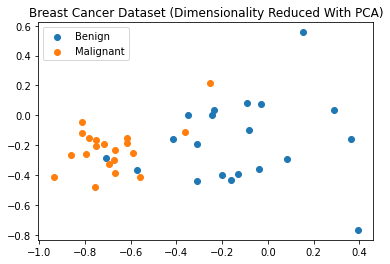

In [9]:
n = 2 # number of principal components kept
training_dataset_size = 20
testing_dataset_size = 10

sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

data_train, _ = split_dataset_to_data_and_labels(training_input)
data_test, _ = split_dataset_to_data_and_labels(test_input)

## Linear Support vector machine

We first emphasize that there two types of data that can be classified by these algorithms: linearly separable datasets and non linearly separable datasets. Our dataset is clearly not linearly separable. We show two examples in the different classes here below.

In [10]:
model= svm.LinearSVC()
model.fit(data_train[0], data_train[1])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

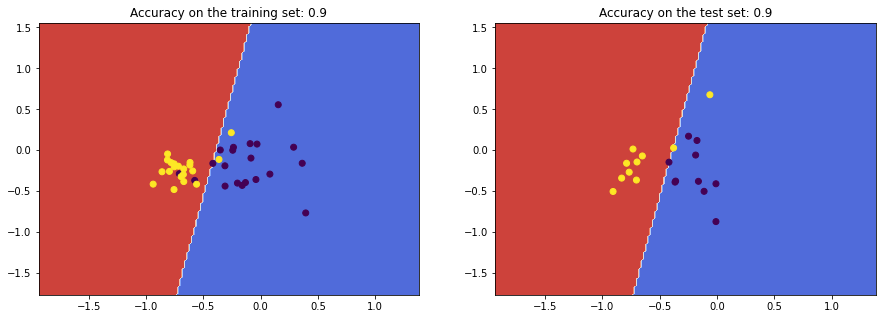

In [11]:
accuracy_train = model.score(data_train[0], data_train[1])
accuracy_test = model.score(data_test[0], data_test[1])


X0, X1 = data_train[0][:, 0], data_train[0][:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[0].scatter(data_train[0][:,0], data_train[0][:,1], c=data_train[1])
ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[1].scatter(data_test[0][:,0], data_test[0][:,1], c=data_test[1])
ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));

We now implement a SVM with gaussian kernel

In [12]:
clf = svm.SVC(gamma = 'scale')
clf.fit(data_train[0], data_train[1]);

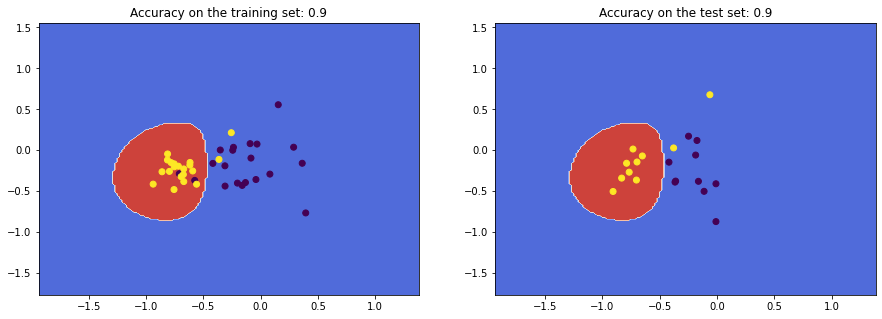

In [13]:
accuracy_train = clf.score(data_train[0], data_train[1])
accuracy_test = clf.score(data_test[0], data_test[1])


X0, X1 = data_train[0][:, 0], data_train[0][:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[0].scatter(data_train[0][:,0], data_train[0][:,1], c=data_train[1])
ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[1].scatter(data_test[0][:,0], data_test[0][:,1], c=data_test[1])
ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));

************************************************************************************************************************************************************************************************************************************************


## Quantum Classification

In [14]:
from qiskit import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap, PauliFeatureMap
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.ml.datasets import ad_hoc_data
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
import functools

In [15]:
def custom_data_map_func(x):
    x1=np.sin(x)
    coeff = x1[0] if len(x1) == 1 else functools.reduce(lambda m, n: m * n, x1)
    return coeff

## **Different Feature Maps used**

In [16]:
feature_map_ZZ_first_order = ZFeatureMap(feature_dimension=2, reps=2) #linear entaglement (no interactions between the qubits |S|=1)
feature_map_ZZ_second_order = ZZFeatureMap(feature_dimension=2, reps=2) #entaglement='full' (default) (full connectivity n(n-1)/2 entaglements)
#feature_map_ZZ_second_order_custommap = ZZFeatureMap(feature_dimension=2, reps=2, data_map_func=custom_data_map_func)
feature_map_pauli_second_order = PauliFeatureMap(feature_dimension=2, reps=2, paulis = ['Y','Z','ZZ']) #We can use additional gates according to our requirements

#ZfeatureMap First order diagonal expansion

In [17]:
print(feature_map_ZZ_first_order)
print("*"*100)

     ┌───┐┌──────────────┐┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├
     └───┘└──────────────┘└───┘└──────────────┘
****************************************************************************************************


In [18]:
qsvm = QSVM(feature_map_ZZ_first_order, training_input, test_input)

In [19]:
from qiskit import BasicAer

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)

result = qsvm.run(quantum_instance)


In [20]:
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.55


## **ZZFeatureMap Second order diagonal expansion**

In [21]:
print(feature_map_ZZ_second_order)
print("*"*100)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘
****************************************************************************************************


In [22]:
qsvm = QSVM(feature_map_ZZ_second_order, training_input, test_input)
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)

result = qsvm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.7


## **Pauli Second order expansion**

In [23]:
print(feature_map_pauli_second_order)
print("*"*100)

     ┌───┐┌─────────┐┌──────────────┐┌──────────┐┌──────────────┐     »
q_0: ┤ H ├┤ RX(π/2) ├┤ U1(2.0*x[0]) ├┤ RX(-π/2) ├┤ U1(2.0*x[0]) ├──■──»
     ├───┤├─────────┤├──────────────┤├──────────┤├──────────────┤┌─┴─┐»
q_1: ┤ H ├┤ RX(π/2) ├┤ U1(2.0*x[1]) ├┤ RX(-π/2) ├┤ U1(2.0*x[1]) ├┤ X ├»
     └───┘└─────────┘└──────────────┘└──────────┘└──────────────┘└───┘»
«                                           ┌───┐┌─────────┐┌──────────────┐»
«q_0: ───────────────────────────────────■──┤ H ├┤ RX(π/2) ├┤ U1(2.0*x[0]) ├»
«     ┌───────────────────────────────┐┌─┴─┐├───┤├─────────┤├──────────────┤»
«q_1: ┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├┤ RX(π/2) ├┤ U1(2.0*x[1]) ├»
«     └───────────────────────────────┘└───┘└───┘└─────────┘└──────────────┘»
«     ┌──────────┐┌──────────────┐                                           
«q_0: ┤ RX(-π/2) ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ RX(-π/2)

In [24]:
qsvm = QSVM(feature_map_pauli_second_order, training_input, test_input)
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)

result = qsvm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.7


## **Custom Feature Map**

In [25]:
from qiskit.aqua.components.feature_maps import FeatureMap
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import BlueprintCircuit
 #"""Mapping data with a custom feature map."""
class CustomFeatureMap(FeatureMap):
    def __init__(self, feature_dimension, depth=2, entangler_map=None):
        self._support_parameterized_circuit = False
        self._feature_dimension = feature_dimension
        self._num_qubits = self._feature_dimension = feature_dimension
        self._depth = depth
        self._entangler_map = None
        if self._entangler_map is None:
            self._entangler_map = [[i, j] for i in range(self._feature_dimension) for j in range(i + 1, self._feature_dimension)]
            
    def construct_circuit(self, x, qr):
        qc = QuantumCircuit(qr)
        for _ in range(self._depth):
            for i in range(self._feature_dimension):
                qc.rx(x[i], qr[i]) #RX gate, qr: qubit store
            for [source, target] in self._entangler_map:
                qc.cx(qr[source], qr[target])
                qc.u1(x[source] * x[target], qr[target])
                qc.cx(qr[source], qr[target])
        return qc

In [26]:
feature_map_custom = CustomFeatureMap(feature_dimension=2, depth=2)

qsvm = QSVM(feature_map_custom, training_input, test_input)
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)

result = qsvm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
                The <class '__main__.CustomFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.


testing success ratio:  0.7


In [27]:
test_set = np.concatenate((test_input['Benign'], test_input['Malignant']))
y_test = qsvm.predict(test_set, quantum_instance)

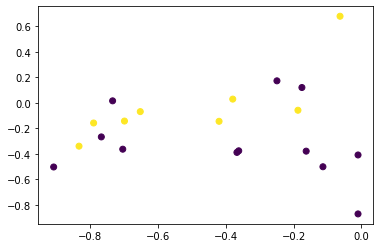

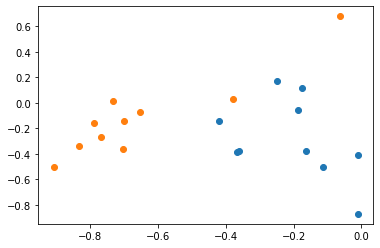

In [28]:
plt.scatter(test_set[:, 0], test_set[:,1], c=y_test)
plt.show()

plt.scatter(test_input['Benign'][:,0], test_input['Benign'][:,1])
plt.scatter(test_input['Malignant'][:,0], test_input['Malignant'][:,1])
plt.show()